In [1]:
# imports
import torch
import scipy.stats as stats
import numpy as np, matplotlib.pyplot as plt
from analysis.ornt import *
from tqdm.notebook import tqdm

# use cpu or gpu as device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
cond_label = ['Baseline',
              'Surround 1',
              'Surround 2']

subs = ['TW', 'MT', 'CMH', 'CR', 'SO',
        'BH', 'DW', 'QF', 'JM', 'MA']

n_sub = len(subs)
n_cond = 3
cond_idx = 0 # baseline
count = 1600 # (400 trials * 4 model average)
model_type = 'avg'

### Compute Fisher Information for Baseline

Second derivative of log-likelihood

In [4]:
# record FI values
all_ornt = np.zeros((len(subs), count))
all_snd = np.zeros((len(subs), count))

In [5]:
for idx in tqdm(range(len(subs))):
    sub_name = 'ORNT_' + subs[idx]
    stim, beta = load_data(sub_name, model_type)
    
    stimulus = stim[cond_idx]
    response = beta[cond_idx].T
    
    # compute the observed FI for each trial
    ornt, _, snd = llhd_derivative(stimulus, response,
                                        batchSize=20,
                                        device=device,
                                        pbar=False)
    
    # record values
    all_ornt[idx] = ornt        
    all_snd[idx] = snd

  0%|          | 0/10 [00:00<?, ?it/s]

Normalized Sqrt FI

In [6]:
# change axis
all_ornt[all_ornt > 90] -= 180

# config the sliding average
center = np.array([10, 20, 35, 50, 65, 80, 90])
center = np.concatenate([-center[::-1], [0], center])
window = 15
config = {'center' : center, 'lb' : -90, 'ub' : 90,
          'cyclical' : True, 'cycle' : 180}

# sliding average
axis, fi_avg = slide_average(all_ornt, all_snd, np.mean, window, config)
error = slide_average(all_ornt, all_snd, np.std, window, config)[-1]
n_data = slide_average(all_ornt, all_snd, np.size, window, config)[-1]

# sem
error = error / np.sqrt(n_data)

In [7]:
# compute normalized fisher information
convert = 180 / (2 * np.pi)

theta = axis
fisher = np.sqrt(-fi_avg)
fi_error = error / (2 * fisher)

scale = 1 / np.trapz(fisher, theta / convert)
fisher *= (scale)
fi_error *= (scale)

Plotting

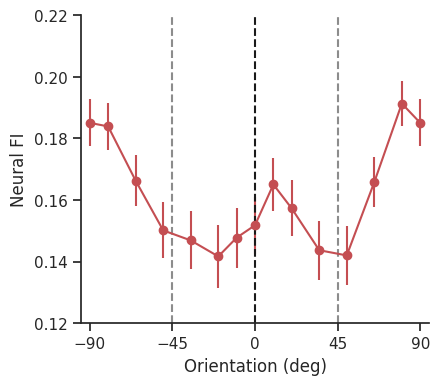

In [8]:
fig = plt.figure(figsize=(4.5, 4))

# plot curve
plt.errorbar(axis, fisher, fi_error, marker='o', color='r')

xpos = [-45, 45]
[plt.axvline(x, color='k', linestyle='--', alpha=0.5) for x in xpos]
plt.axvline(0, color='k', linestyle='--')

plt.xlim([-95, 95])
plt.xticks(np.arange(-90, 91, 45))
plt.xlabel('Orientation (deg)')
plt.yticks([0.12, 0.14, 0.16, 0.18, 0.20, 0.22])
plt.ylabel('Neural FI')

plt.show()